In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [35]:
#!pip install tensorflow==2.5.0
from IPython.core.display import display, HTML
display(HTML("<style>.container { maxwidth:1200px !important; }</style>"))

In [1]:
import tensorflow as tf
print(tf.__version__)

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

2.7.0


In [2]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O ./daily-min-temperatures.csv 

--2022-01-05 02:16:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘./daily-min-temperatures.csv’

./daily-min-tempera 100%[===================>]  66.33K   295KB/s    in 0.2s    

2022-01-05 02:16:56 (295 KB/s) - ‘./daily-min-temperatures.csv’ saved [67921/67921]



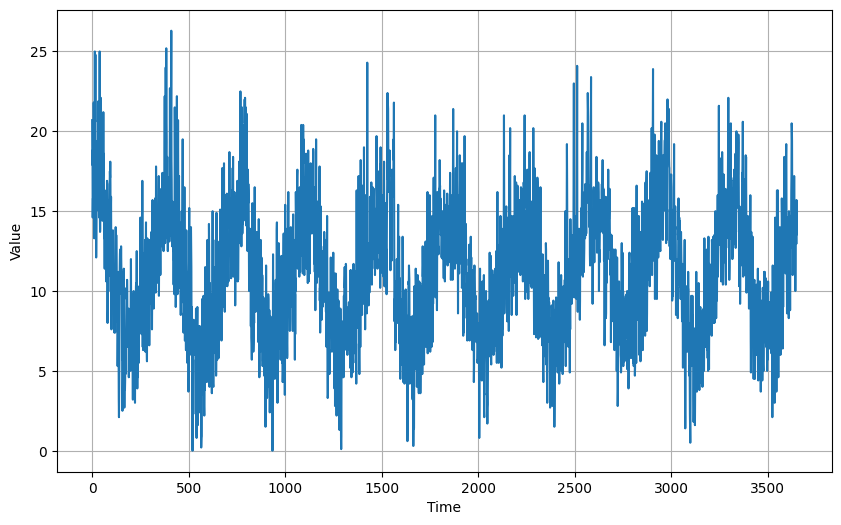

In [17]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    step=0
    for row in reader:
        temps.append(float(row[1]))
        time_step.append(step)
        step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [6]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [22]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [23]:
def model_forecast(model, series, window_size):
    # YOUR CODE HERE
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast    

In [24]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)    
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule], validation_data=valid_set)


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(2500,)
Epoch 1/100
10/10 [==============================] - 5s 141ms/step - loss: 9.6913 - mae: 10.1800 - val_loss: 10.6686 - val_mae: 11.1580 - lr: 1.0000e-08
Epoch 2/100
10/10 [==============================] - 1s 49ms/step - loss: 9.2707 - mae: 9.7593 - val_loss: 10.0288 - val_mae: 10.5166 - lr: 1.1220e-08
Epoch 3/100
10/10 [==============================] - 1s 46ms/step - loss: 8.6240 - mae: 9.1111 - val_loss: 9.2060 - val_mae: 9.6928 - lr: 1.2589e-08
Epoch 4/100
10/10 [==============================] - 1s 51ms/step - loss: 7.8392 - mae: 8.3254 - val_loss: 8.2432 - val_mae: 8.7283 - lr: 1.4125e-08
Epoch 5/100
10/10 [==============================] - 1s 46ms/step - loss: 6.9536 - mae: 7.4388 - val_loss: 7.1555 - val_mae: 7.6415 - lr: 1.5849e-08
Epoch 6/100
10/10 [==============================] - 1s 45ms/step - loss: 6.0008 - mae: 6.4847 - val_loss: 6.0089 - val_mae: 6.4933 - lr: 1.7783e-0

Epoch 55/100
10/10 [==============================] - 1s 47ms/step - loss: 1.9112 - mae: 2.3653 - val_loss: 1.7485 - val_mae: 2.2019 - lr: 5.0119e-06
Epoch 56/100
10/10 [==============================] - 1s 47ms/step - loss: 1.9022 - mae: 2.3560 - val_loss: 1.7373 - val_mae: 2.1910 - lr: 5.6234e-06
Epoch 57/100
10/10 [==============================] - 1s 46ms/step - loss: 1.8920 - mae: 2.3458 - val_loss: 1.7222 - val_mae: 2.1756 - lr: 6.3096e-06
Epoch 58/100
10/10 [==============================] - 1s 47ms/step - loss: 1.8808 - mae: 2.3345 - val_loss: 1.7127 - val_mae: 2.1659 - lr: 7.0795e-06
Epoch 59/100
10/10 [==============================] - 1s 48ms/step - loss: 1.8695 - mae: 2.3230 - val_loss: 1.7070 - val_mae: 2.1595 - lr: 7.9433e-06
Epoch 60/100
10/10 [==============================] - 1s 45ms/step - loss: 1.8605 - mae: 2.3142 - val_loss: 1.7119 - val_mae: 2.1640 - lr: 8.9125e-06
Epoch 61/100
10/10 [==============================] - 1s 48ms/step - loss: 1.8529 - mae: 2.3065 - va

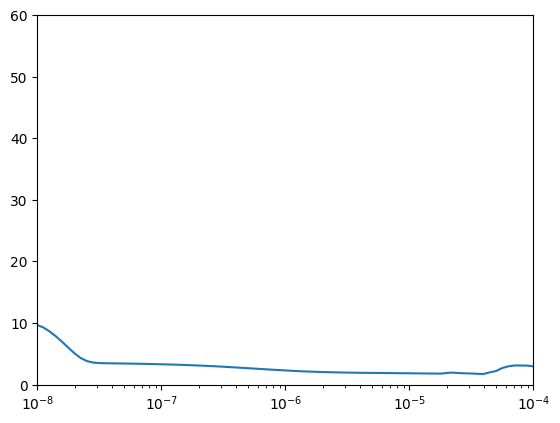

In [26]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])
plt.show()

In [27]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
valid_set = windowed_dataset(x_valid, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
# YOUR CODE HERE
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)       
])


optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)# YOUR CODE HERE, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150, validation_data=valid_set)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/150
25/25 [==============================] - 5s 61ms/step - loss: 3.7463 - mae: 4.2191 - val_loss: 2.1831 - val_mae: 2.6428
Epoch 2/150
25/25 [==============================] - 1s 24ms/step - loss: 2.1196 - mae: 2.5777 - val_loss: 1.8167 - val_mae: 2.2680
Epoch 3/150
25/25 [==============================] - 1s 24ms/step - loss: 1.9067 - mae: 2.3608 - val_loss: 1.7026 - val_mae: 2.1515
Epoch 4/150
25/25 [==============================] - 1s 22ms/step - loss: 1.8056 - mae: 2.2576 - val_loss: 1.6169 - val_mae: 2.0631
Epoch 5/150
25/25 [==============================] - 1s 22ms/step - loss: 1.7683 - mae: 2.2188 - val_loss: 1.5858 - val_mae: 2.0301
Epoch 6/150
25/25 [==============================] - 1s 22ms/step - loss: 1.7224 - mae: 2.1720 - val_loss: 1.5665 - val_mae: 2.0121
Epoch 7/150
25/25 [==============================] - 1s 22ms/step - loss: 1.6779 - mae: 2.1270 - val_loss: 1.6218 - val_mae: 2.0691
Epoch 8/150
25/25 [==============================] - 1s 22ms/step - loss: 1.

25/25 [==============================] - 1s 22ms/step - loss: 1.5429 - mae: 1.9868 - val_loss: 1.3833 - val_mae: 1.8219
Epoch 63/150
25/25 [==============================] - 1s 22ms/step - loss: 1.4932 - mae: 1.9345 - val_loss: 1.3819 - val_mae: 1.8202
Epoch 64/150
25/25 [==============================] - 1s 22ms/step - loss: 1.4976 - mae: 1.9386 - val_loss: 1.4762 - val_mae: 1.9177
Epoch 65/150
25/25 [==============================] - 1s 22ms/step - loss: 1.5317 - mae: 1.9759 - val_loss: 1.3804 - val_mae: 1.8183
Epoch 66/150
25/25 [==============================] - 1s 22ms/step - loss: 1.5052 - mae: 1.9473 - val_loss: 1.3837 - val_mae: 1.8219
Epoch 67/150
25/25 [==============================] - 1s 23ms/step - loss: 1.4934 - mae: 1.9345 - val_loss: 1.3800 - val_mae: 1.8179
Epoch 68/150
25/25 [==============================] - 1s 22ms/step - loss: 1.4917 - mae: 1.9326 - val_loss: 1.3808 - val_mae: 1.8190
Epoch 69/150
25/25 [==============================] - 1s 24ms/step - loss: 1.4951 

25/25 [==============================] - 1s 23ms/step - loss: 1.4884 - mae: 1.9281 - val_loss: 1.4093 - val_mae: 1.8482
Epoch 124/150
25/25 [==============================] - 1s 22ms/step - loss: 1.4898 - mae: 1.9302 - val_loss: 1.3721 - val_mae: 1.8110
Epoch 125/150
25/25 [==============================] - 1s 21ms/step - loss: 1.4840 - mae: 1.9238 - val_loss: 1.3739 - val_mae: 1.8126
Epoch 126/150
25/25 [==============================] - 1s 22ms/step - loss: 1.4791 - mae: 1.9187 - val_loss: 1.3728 - val_mae: 1.8115
Epoch 127/150
25/25 [==============================] - 1s 21ms/step - loss: 1.4782 - mae: 1.9177 - val_loss: 1.3809 - val_mae: 1.8198
Epoch 128/150
25/25 [==============================] - 1s 22ms/step - loss: 1.4890 - mae: 1.9292 - val_loss: 1.3742 - val_mae: 1.8132
Epoch 129/150
25/25 [==============================] - 1s 23ms/step - loss: 1.4836 - mae: 1.9233 - val_loss: 1.4244 - val_mae: 1.8664
Epoch 130/150
25/25 [==============================] - 1s 22ms/step - loss: 

In [28]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

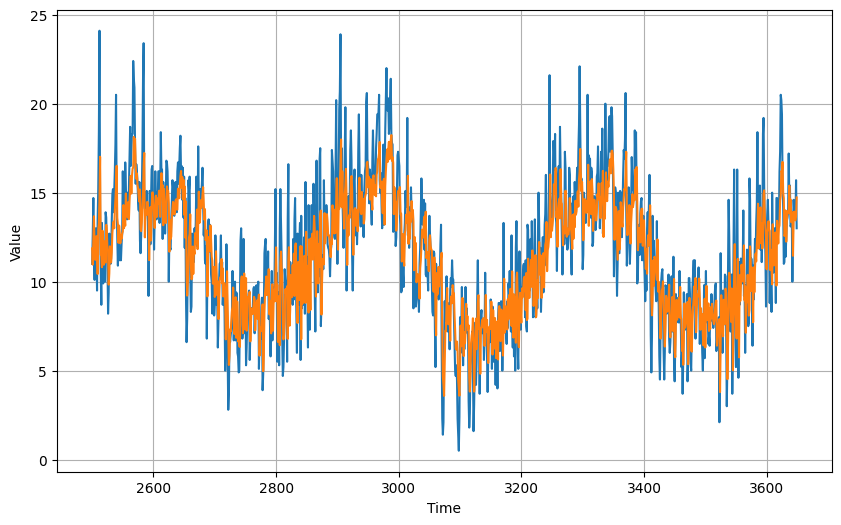

In [29]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)
plt.show() 
# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [30]:
print(tf.keras.metrics.mean_squared_error(x_valid, rnn_forecast).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

5.4032607
1.8121678


In [31]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.866026 10.95599  12.409695 ... 13.443708 13.663951 14.729939]
